# Load in packages and data

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.ensemble import GradientBoostingClassifier

from functions import get_eff_faker_err, train_test_split_by_part, get_eff_faker_vs_feat

In [2]:
# Take in .root into arrays
arrays = (uproot.open("TTbar_PU200_D49_prompt.root")["L1TrackNtuple/eventTree"]
                .arrays("*", namedecode="utf-8"))

In [3]:
# A look at what variables you can use as inputs to your model
arrays.keys()

dict_keys([&#39;trk_pt&#39;, &#39;trk_eta&#39;, &#39;trk_phi&#39;, &#39;trk_d0&#39;, &#39;trk_z0&#39;, &#39;trk_chi2&#39;, &#39;trk_chi2rphi&#39;, &#39;trk_chi2rz&#39;, &#39;trk_bendchi2&#39;, &#39;trk_nstub&#39;, &#39;trk_lhits&#39;, &#39;trk_dhits&#39;, &#39;trk_seed&#39;, &#39;trk_hitpattern&#39;, &#39;trk_phiSector&#39;, &#39;trk_genuine&#39;, &#39;trk_loose&#39;, &#39;trk_unknown&#39;, &#39;trk_combinatoric&#39;, &#39;trk_fake&#39;, &#39;trk_matchtp_pdgid&#39;, &#39;trk_matchtp_pt&#39;, &#39;trk_matchtp_eta&#39;, &#39;trk_matchtp_phi&#39;, &#39;trk_matchtp_z0&#39;, &#39;trk_matchtp_dxy&#39;, &#39;trk_injet&#39;, &#39;trk_injet_highpt&#39;, &#39;trk_injet_vhighpt&#39;, &#39;tp_pt&#39;, &#39;tp_eta&#39;, &#39;tp_phi&#39;, &#39;tp_dxy&#39;, &#39;tp_d0&#39;, &#39;tp_z0&#39;, &#39;tp_d0_prod&#39;, &#39;tp_z0_prod&#39;, &#39;tp_pdgid&#39;, &#39;tp_nmatch&#39;, &#39;tp_nloosematch&#39;, &#39;tp_nstub&#39;, &#39;tp_eventid&#39;, &#39;tp_charge&#39;, &#39;tp_injet&#39;, &#39;tp_injet_highp

# Create train and test samples

In [4]:
# Select features from data and put in proper format
# 'trk_fake' is the track quality variable, truth data

features = ['trk_pt','trk_eta','trk_phi','trk_z0','trk_chi2rphi','trk_chi2rz','trk_bendchi2','trk_bendchi2']
X = np.empty((len(arrays[features[0]].flatten()),len(features)))
for i in range(len(features)):
    X[:,i] = arrays[features[i]].flatten()

y = arrays['trk_fake'].flatten()
y[y==2] = 1

# Grab pdgid for certain studies
pdgid = arrays['trk_matchtp_pdgid'].flatten()

In [5]:
# Get rid of any nan instances for training purposes (doesn't converge)
find_nan = np.argwhere(np.isnan(X))
X = np.delete(X, find_nan[:,0], 0)
y = np.delete(y, find_nan[:,0])
pdgid = np.delete(pdgid, find_nan[:,0])

In [6]:
# Create train and test sets with 2500 of each mu, elec, had, fake in train, rest in test
X_train, y_train, pdgid_train, X_test, y_test, pdgid_test = train_test_split_by_part(X,y,pdgid,2500,2500,2500,2500)

# Train gradient boosted decision tree (GBDT)

In [7]:
# This creates GBDT with 500 trees that each have a max depth of 3
# Visit https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
#   for more information on how to configure GBDT
clf_GBDT = GradientBoostingClassifier(n_estimators=500, max_depth=3)
clf_GBDT.fit(X_train,y_train)

GradientBoostingClassifier(n_estimators=500)

In [11]:
# Create a GBDT with 500 trees, max depth of 3 using the XGBoost sklearn API
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
import xgboost as xgb
clf_GBDT = xgb.XGBClassifier(n_estimators=500, max_depth=3)
clf_GBDT.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=&#39;gbtree&#39;, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=7, gpu_id=-1,
              importance_type=&#39;gain&#39;, interaction_constraints=&#39;&#39;,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=nan, monotone_constraints=&#39;()&#39;,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=34, reg_lambda=1, scale_pos_weight=1, subsample=0.66,
              tree_method=&#39;exact&#39;, validate_parameters=1, verbosity=None)

# Check GBDT performance

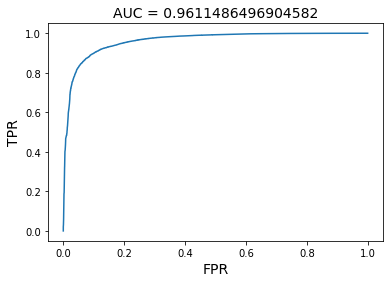

In [12]:
# Create roc curve with AUC (area under curve) value
y_pred = clf_GBDT.predict_proba(X_test)[:,1]
fpr, tpr, dt = roc_curve(y_test,y_pred)
auc = roc_auc_score(y_test, y_pred)

plt.plot(fpr,tpr)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.title('AUC = '+str(auc),fontsize=14)
plt.show()

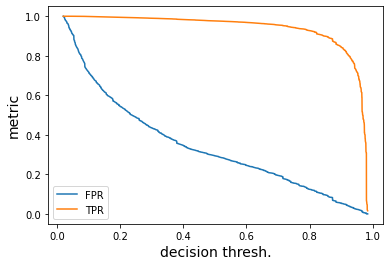

In [12]:
# Plot TPR and FPR vs decision threshold (dt)
plt.plot(dt[1:],fpr[1:],label='FPR')
plt.plot(dt[1:],tpr[1:],label='TPR')
plt.xlabel('decision thresh.',fontsize=14)
plt.ylabel('metric',fontsize=14)
plt.legend(loc='best')
plt.show()

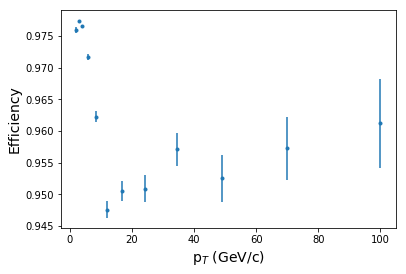

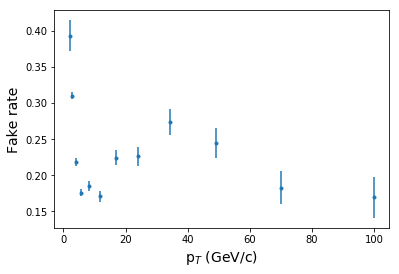

In [13]:
# Create efficiency/fake rate vs. pt
pt, eff, faker, err_eff, err_faker = get_eff_faker_vs_feat('pt',features,X_test,y_test,clf_GBDT)

plt.errorbar(pt,eff,yerr=err_eff,linestyle='None',fmt='.')
plt.xlabel('p$_{T}$ (GeV/c)',fontsize=14)
plt.ylabel('Efficiency',fontsize=14)
plt.show()

plt.errorbar(pt,faker,yerr=err_faker,linestyle='None',fmt='.')
plt.xlabel('p$_{T}$ (GeV/c)',fontsize=14)
plt.ylabel('Fake rate',fontsize=14)
plt.show()

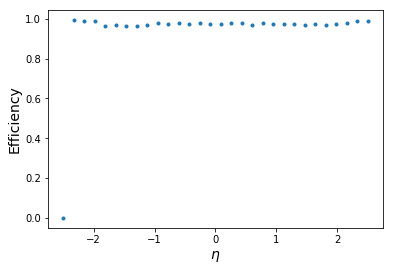

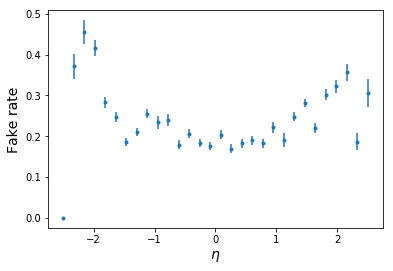

In [14]:
# Create efficiency/fake rate vs. eta
pt, eff, faker, err_eff, err_faker = get_eff_faker_vs_feat('eta',features,X_test,y_test,clf_GBDT)

plt.errorbar(pt,eff,yerr=err_eff,linestyle='None',fmt='.')
plt.xlabel('$\eta$',fontsize=14)
plt.ylabel('Efficiency',fontsize=14)
plt.show()

plt.errorbar(pt,faker,yerr=err_faker,linestyle='None',fmt='.')
plt.xlabel('$\eta$',fontsize=14)
plt.ylabel('Fake rate',fontsize=14)
plt.show()